This notebook is for creating graphs of the benchmark case study, specifically using datasets where all the data is available.

Currently this notebook resides in the `notebooks` folder, but in order for it to run, it must be moved out to the main folder. 

# Set up 

In [2]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp


In [3]:
# import sys
# sys.path.insert(0, 'C:/Users/user/Documents/research/BMCA-pipeline')
os.chdir('../..')
from src import BMCA, util
import emll

# Perturbing enzymes

In [4]:
pt_levels= np.logspace(-1, 0, num=20)
pt_levels = pt_levels.round(3)
pt_levels

array([0.1  , 0.113, 0.127, 0.144, 0.162, 0.183, 0.207, 0.234, 0.264,
       0.298, 0.336, 0.379, 0.428, 0.483, 0.546, 0.616, 0.695, 0.785,
       0.886, 1.   ])

In [7]:
#Teusink_ant ='data/interim/Antimony/flatTeusink.ant' 
#data_file = "data/interim/generated_data/flatTeusink/flatTeusink_0.5.csv"
Teusink_ant ='data/interim/Antimony/BIOMD0000000064_e.ant' 
data_file = 'data/interim/generated_data/ogTeusink/BIOMD0000000064_e_extANDenzyme1.5perts.csv'

data = pd.read_csv(data_file)

# need to fix this so only rows with concentrations less than 0 are dropped 
#data = df.drop(df[df.lt(0).any(axis=1)].index)

r = te.loada(Teusink_ant)

r.conservedMoietyAnalysis = True
r.steadyState()


5.935978122618177e-12

In [8]:
BIOMD64 = BMCA.BMCA(Teusink_ant, data_file)

Model does not contain SBML fbc package information.


Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-23


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGAPDH>'
Missing upper flux bound set to '1

In [13]:
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BIOMD64.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BIOMD64.Ey.to_numpy(), name='Ey'))

    trace_prior = pm.sample_prior_predictive(samples=1000)

Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]


In [14]:
with pymc_model:
    
    e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BIOMD64.en.T)
    chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BIOMD64.xn.T)
    y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BIOMD64.yn.T)


In [15]:
with pymc_model:
    
    likelihood = pm.Deterministic('vn', e_obs * (np.ones((17,23)) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
    v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BIOMD64.vn.squeeze().T)

pymc_model.free_RVs

[Ex_kinetic_entries ~ SkewNormal(0, 1, 5),
 Ex_capacity_entries ~ Laplace(0, 0.01),
 Ey_kinetic_entries ~ SkewNormal(0, 1, 5),
 Ey_capacity_entries ~ Laplace(0, 0.01)]

In [16]:
N_ITERATIONS = 50000
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = advi.fit(
        n=       N_ITERATIONS, 
        callbacks = [tracker],
        obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
        total_grad_norm_constraint=0.7,
        obj_n_mc=1)
    
    trace_vi = approx.sample(draws=1000, random_seed=1) 
    ppc_vi = pm.sample_posterior_predictive(trace_vi, random_seed=1)
    

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 11,018
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


In [17]:
# takig the median peaks can only be done if the distributions are unimodal!
Ex_trace = (trace_vi['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
Ex_trace.shape

(17, 14, 1000)

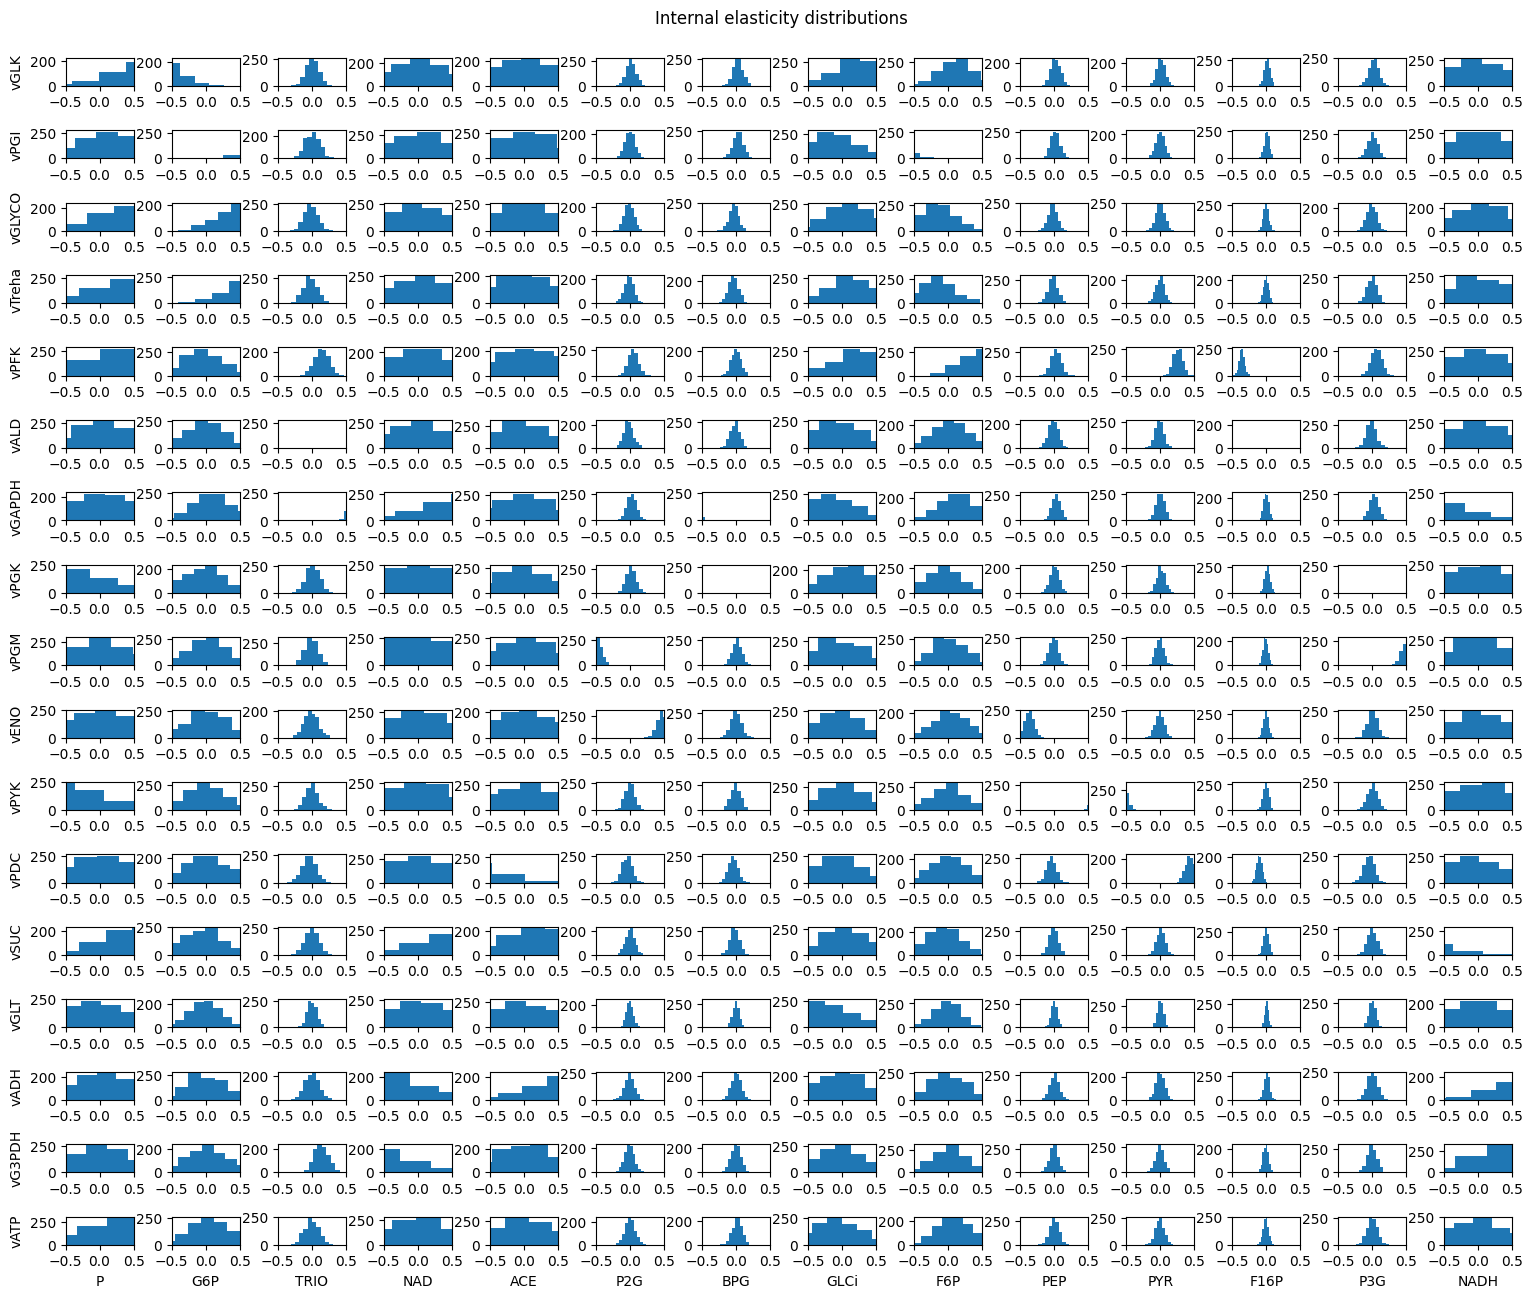

In [18]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,14, figsize=(15, 13)) 

fig.suptitle('Internal elasticity distributions\n')
fig.tight_layout()

for i in range(17):
  for ii in range(14):
    axs[i,ii].hist(Ex_trace[i,ii,:])
    axs[i,ii].set_xlim([-0.5,0.5])

    if ii == 0:
      axs[i,ii].set_ylabel(r.getReactionIds()[i])
    if i == 16: 
      axs[i,ii].set_xlabel(r.getFloatingSpeciesIds()[ii])

In [19]:
Ex_peaks=[]

for i in range(Ex_trace.shape[0]):
    for ii in range(Ex_trace.shape[1]):
        Ex_peaks.append(np.percentile(Ex_trace[i,ii,:],50))


In [20]:
# these are the elasticity posteriors from Bayesian inference
x = np.array(Ex_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
x[abs(x) < 0.01] = 0

x = x.reshape((17,14))
Ex = pd.DataFrame(x, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds())
Ex

,P,G6P,TRIO,NAD,ACE,P2G,BPG,GLCi,F6P,PEP,PYR,F16P,P3G,NADH
vGLK,1.042990,-0.800090,0.000000,0.000000,0.000000,0.013349,0.029981,0.269391,0.121625,0.019658,0.012619,0.014119,0.022724,0.000000
vPGI,0.116056,1.095820,0.014305,0.019769,0.000000,0.000000,0.034287,-0.156197,-1.054721,0.017853,0.000000,0.000000,0.000000,0.000000
vGLYCO,0.679089,0.580035,-0.013332,0.000000,-0.013501,-0.014600,-0.031563,0.127203,-0.169198,-0.019765,0.000000,0.000000,-0.015343,0.021347
vTreha,0.655141,0.748189,-0.021746,0.032325,0.012892,0.000000,-0.039905,0.139998,-0.177209,-0.013576,0.000000,0.000000,0.000000,0.017934
vPFK,0.472519,-0.050340,0.150229,0.015465,0.055044,0.048759,0.000000,0.253159,0.539754,0.029502,0.263272,-0.362402,0.058573,-0.012636
vALD,0.038042,0.000000,-1.356461,-0.023927,-0.033530,-0.016352,0.000000,-0.095420,0.044669,-0.013727,-0.013820,0.612199,-0.016755,0.000000
vGAPDH,0.060126,0.097974,0.671858,0.800758,-0.033882,0.024844,-0.632783,-0.143204,0.132553,0.029905,0.000000,0.000000,0.022163,-0.940153
vPGK,-0.629171,-0.018433,0.017127,-0.041762,-0.025896,0.015754,0.930815,0.099943,-0.053545,0.010463,0.000000,0.016792,-0.984127,0.019986
vPGM,0.027061,0.023930,0.000000,-0.036038,0.036779,-0.483438,0.010251,-0.047382,0.016145,0.000000,0.000000,-0.011074,0.512242,-0.016596
vENO,0.000000,0.000000,-0.010217,0.000000,-0.017215,0.473119,0.000000,-0.056045,0.030190,-0.364424,0.000000,0.000000,0.000000,0.000000


In [21]:
Ey_trace = (trace_vi['posterior']['Ey']).to_numpy().squeeze().transpose(1, 2, 0)
Ey_trace.shape

(17, 5, 1000)

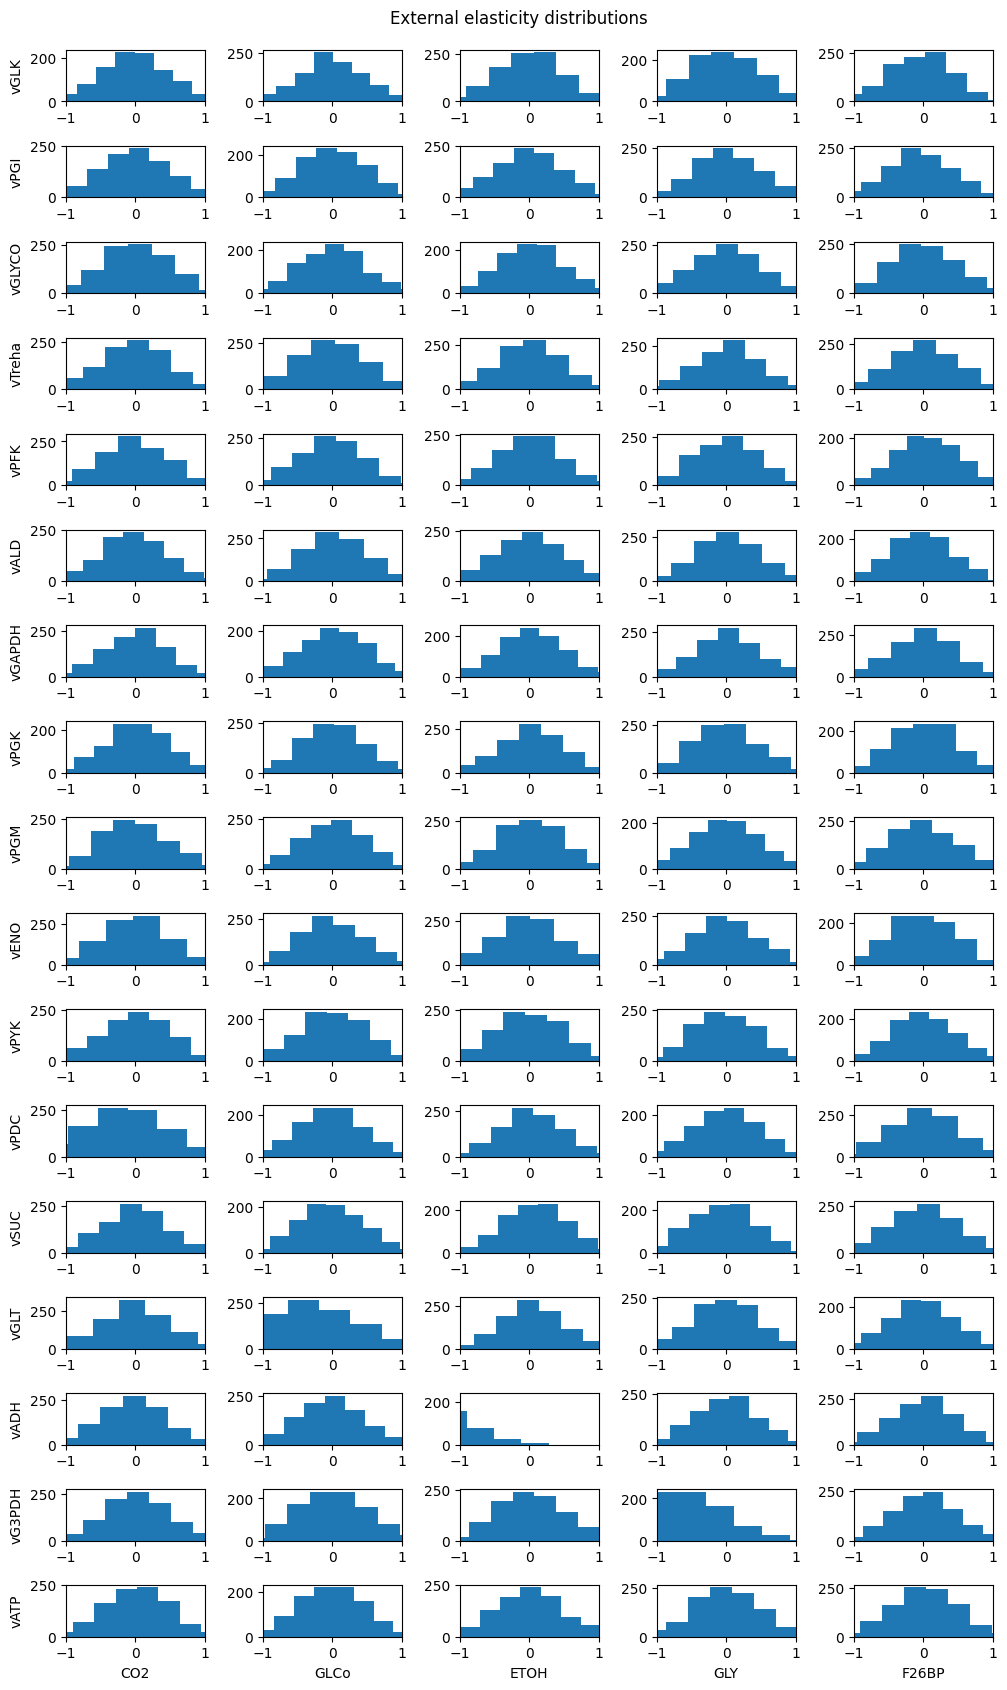

In [22]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,5, figsize=(10, 17)) 

fig.suptitle('External elasticity distributions\n')
fig.tight_layout()

for i in range(17):
  for ii in range(5):
    axs[i,ii].hist(Ey_trace[i,ii,:])
    axs[i,ii].set_xlim([-1,1])

    if ii == 0:
      axs[i,ii].set_ylabel(r.getReactionIds()[i])
    if i == 16: 
      axs[i,ii].set_xlabel(r.getBoundarySpeciesIds()[ii])

In [23]:
Ey_peaks=[]

for i in range(Ey_trace.shape[0]):
    for ii in range(Ey_trace.shape[1]):
        Ey_peaks.append(np.percentile(Ey_trace[i,ii,:],50))


In [24]:
# elasticities from Bayesian inf posteriors

y = np.array(Ey_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
y[abs(y) < 0.01] = 0

y = y.reshape((17,5))
Ey = pd.DataFrame(y, index=r.getReactionIds(), columns=r.getBoundarySpeciesIds())
Ey

,CO2,GLCo,ETOH,GLY,F26BP
vGLK,-0.013424,-0.016807,0.000000,-0.018076,-0.031490
vPGI,0.000000,0.014865,0.000000,0.000000,-0.048457
vGLYCO,0.000000,0.013534,0.041644,-0.011455,0.000000
vTreha,0.000000,0.000000,0.000000,0.045154,0.000000
vPFK,0.000000,-0.012251,0.020833,0.000000,0.044007
vALD,-0.024591,0.032042,-0.012546,0.039026,-0.033035
vGAPDH,0.024720,0.027703,0.035207,0.016635,0.000000
vPGK,0.000000,0.000000,0.021550,-0.020906,0.020649
vPGM,-0.036238,0.012670,0.010953,0.000000,-0.035563
vENO,0.000000,-0.016906,-0.021628,-0.018330,-0.032411


In [25]:
enzymes = [i for i in data.columns if 'e_' in i]

In [30]:
a = data[enzymes].apply(lambda row: row[row != 1].index, axis=1)
pt_enz = [i[0] for i in a[1:] if len(i)!=0]

a = data[data[enzymes] != 1].values.flatten()
pt_lvls = a[~np.isnan(a)]

In [44]:
# zip pt_enz and pt_lvls together and then assign them as the column names
enzPtLvls = [x +'|'+ str(y) for x, y in zip(pt_enz, pt_lvls)]
enzPtLvls.insert(len(enzPtLvls), 'unperturbed')
enzPtLvls

['e_vGLK|1.5',
 'e_vPGI|1.5',
 'e_vGLYCO|1.5',
 'e_vTreha|1.5',
 'e_vPFK|1.5',
 'e_vALD|1.5',
 'e_vGAPDH|1.5',
 'e_vPGK|1.5',
 'e_vPGM|1.5',
 'e_vENO|1.5',
 'e_vPYK|1.5',
 'e_vPDC|1.5',
 'e_vSUC|1.5',
 'e_vGLT|1.5',
 'e_vADH|1.5',
 'e_vG3PDH|1.5',
 'e_vATP|1.5',
 'unperturbed']

In [45]:
# get the real values
real_values = data[[i for i in data.columns if 'v_' in i]].iloc[:len(enzPtLvls)+1]
rel_real_values = real_values.div(real_values.iloc[0])
rel_real_values.drop(rel_real_values.index[0], inplace=True)
rel_real_values.columns = r.getReactionIds()
rel_real_values = rel_real_values.transpose()
rel_real_values.columns = enzPtLvls
rel_real_values

,e_vGLK|1.5,e_vPGI|1.5,e_vGLYCO|1.5,e_vTreha|1.5,e_vPFK|1.5,e_vALD|1.5,e_vGAPDH|1.5,e_vPGK|1.5,e_vPGM|1.5,e_vENO|1.5,e_vPYK|1.5,e_vPDC|1.5,e_vSUC|1.5,e_vGLT|1.5,e_vADH|1.5,e_vG3PDH|1.5,e_vATP|1.5,unperturbed
vGLK,1.038801,1.000664,0.986642,0.991448,1.000496,1.000108,1.004875,1.000126,1.000102,1.000238,1.000129,1.000050,0.991318,1.361262,1.001866,0.983224,0.950282,1.0
vPGI,1.044219,1.000757,0.945992,0.959226,1.000565,1.000124,1.005556,1.000144,1.000116,1.000272,1.000147,1.000056,0.990105,1.411704,1.002127,0.980881,0.943340,1.0
vGLYCO,1.000000,1.000000,1.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
vTreha,1.000000,1.000000,1.000000,1.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
vPFK,1.044219,1.000757,0.945992,0.959226,1.000565,1.000124,1.005556,1.000144,1.000116,1.000272,1.000147,1.000056,0.990105,1.411704,1.002127,0.980881,0.943340,1.0
vALD,1.044219,1.000757,0.945992,0.959226,1.000565,1.000124,1.005556,1.000144,1.000116,1.000272,1.000147,1.000056,0.990105,1.290330,1.002127,0.980881,0.943340,1.0
vGAPDH,1.046977,1.000805,0.942795,0.956795,1.000601,1.000131,1.018649,1.000454,1.000366,1.000858,1.000465,1.000178,0.969893,1.276225,1.007268,0.945959,0.940583,1.0
vPGK,1.046977,1.000805,0.942795,0.956795,1.000601,1.000131,1.018649,1.000454,1.000366,1.000858,1.000465,1.000178,0.969893,1.276226,1.007268,0.945959,0.940583,1.0
vPGM,1.046977,1.000805,0.942795,0.956795,1.000601,1.000131,1.018649,1.000454,1.000366,1.000858,1.000465,1.000178,0.969893,1.276225,1.007268,0.945959,0.940583,1.0
vENO,1.046977,1.000805,0.942795,0.956795,1.000601,1.000131,1.018649,1.000454,1.000366,1.000858,1.000465,1.000178,0.969893,1.276225,1.007268,0.945959,0.940583,1.0


Text(-9, 4, 'r = 0.532')

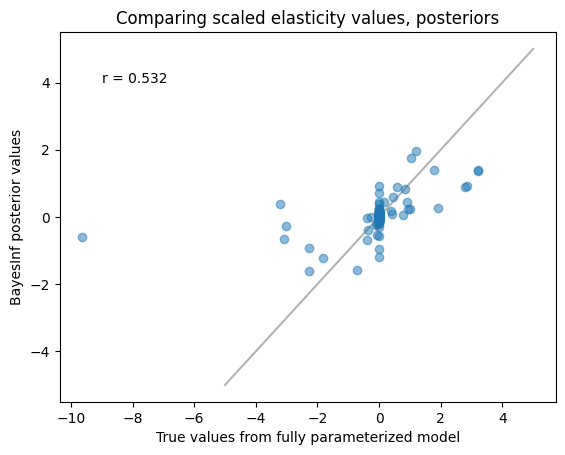

In [24]:
plt.scatter(r.getScaledElasticityMatrix(), x, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled elasticity values, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-9,4,'r = ' + str((stats.pearsonr(r.getScaledElasticityMatrix().flatten(), x.flatten())[0]).round(3)))

# the dot all the way to the left is P on PGK

## Plotting MCC and FCC comparisons

In [46]:
gtCCC = pd.DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [47]:
visCCC, visFCC = util.elasticity_to_CCC(BIOMD64, BIOMD64.Ex)  
visCCC = pd.DataFrame(visCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
visFCC.columns = r.getReactionIds()
visFCC.index = r.getReactionIds()
visFCC

,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH,vATP
vGLK,0.139587,0.079511,0.031414,0.028661,0.079511,0.079511,0.077840,0.077840,0.077840,0.077840,0.077840,0.077840,0.000836,0.139587,0.077004,0.001671,-0.124330
vPGI,0.082789,0.110380,-0.015836,-0.011755,0.110380,0.110380,0.075443,0.075443,0.075443,0.075443,0.075443,0.075443,0.017469,0.082789,0.057974,0.034937,-0.032161
vGLYCO,0.546373,-0.141574,0.814264,-0.126317,-0.141574,-0.141574,0.095007,0.095007,0.095007,0.095007,0.095007,0.095007,-0.118290,0.546373,0.213298,-0.236581,-0.784441
vTreha,0.546373,-0.141574,-0.185736,0.873683,-0.141574,-0.141574,0.095007,0.095007,0.095007,0.095007,0.095007,0.095007,-0.118290,0.546373,0.213298,-0.236581,-0.784441
vPFK,0.082789,0.110380,-0.015836,-0.011755,0.110380,0.110380,0.075443,0.075443,0.075443,0.075443,0.075443,0.075443,0.017469,0.082789,0.057974,0.034937,-0.032161
vALD,0.082789,0.110380,-0.015836,-0.011755,0.110380,0.110380,0.075443,0.075443,0.075443,0.075443,0.075443,0.075443,0.017469,0.082789,0.057974,0.034937,-0.032161
vGAPDH,0.068474,0.075238,-0.003063,-0.003702,0.075238,0.075238,0.087462,0.087462,0.087462,0.087462,0.087462,0.087462,-0.006112,0.068474,0.093574,-0.012224,0.044089
vPGK,0.068474,0.075238,-0.003063,-0.003702,0.075238,0.075238,0.087462,0.087462,0.087462,0.087462,0.087462,0.087462,-0.006112,0.068474,0.093574,-0.012224,0.044089
vPGM,0.068474,0.075238,-0.003063,-0.003702,0.075238,0.075238,0.087462,0.087462,0.087462,0.087462,0.087462,0.087462,-0.006112,0.068474,0.093574,-0.012224,0.044089
vENO,0.068474,0.075238,-0.003063,-0.003702,0.075238,0.075238,0.087462,0.087462,0.087462,0.087462,0.087462,0.087462,-0.006112,0.068474,0.093574,-0.012224,0.044089


In [48]:
postCCC, postFCC = util.elasticity_to_CCC(BIOMD64, Ex)  
postCCC = pd.DataFrame(postCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
postFCC = pd.DataFrame(postFCC) #, index=r.getReactionIds(), columns=r.getReactionIds())
postFCC.columns = r.getReactionIds()
postFCC.index = r.getReactionIds()
postFCC

,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH,vATP
vGLK,0.369914,0.334122,-0.068608,-0.039247,0.489646,0.226753,0.304656,0.166634,0.211857,0.111620,-0.014534,-0.319296,-0.411871,0.489185,-0.368507,0.068539,-0.550863
vPGI,0.501689,0.516396,-0.159666,-0.110846,0.717713,0.321505,0.402691,0.203252,0.227388,0.075296,-0.075918,-0.535748,-0.617793,0.603590,-0.646121,0.171361,-0.594789
vGLYCO,-0.845259,-1.186707,1.115237,0.090211,-1.442012,-0.571545,-0.543019,-0.163349,0.060748,0.417453,0.511242,1.524376,1.383871,-0.702383,1.989824,-0.708394,0.069707
vTreha,-0.234600,-0.702105,-0.081057,0.952721,-0.770965,-0.302266,-0.215520,-0.010966,0.150459,0.314681,0.317412,0.864114,0.661780,0.135067,1.157187,-0.617220,-0.618722
vPFK,0.501689,0.516396,-0.159666,-0.110846,0.717713,0.321505,0.402691,0.203252,0.227388,0.075296,-0.075918,-0.535748,-0.617793,0.603590,-0.646121,0.171361,-0.594789
vALD,0.501689,0.516396,-0.159666,-0.110846,0.717713,0.321505,0.402691,0.203252,0.227388,0.075296,-0.075918,-0.535748,-0.617793,0.603590,-0.646121,0.171361,-0.594789
vGAPDH,0.454824,0.457288,-0.136734,-0.095234,0.628085,0.284646,0.376277,0.193394,0.229124,0.096519,-0.049452,-0.447875,-0.555507,0.514351,-0.522774,0.071572,-0.498503
vPGK,0.454824,0.457288,-0.136734,-0.095234,0.628085,0.284646,0.376277,0.193394,0.229124,0.096519,-0.049452,-0.447875,-0.555507,0.514351,-0.522774,0.071572,-0.498503
vPGM,0.454824,0.457288,-0.136734,-0.095234,0.628085,0.284646,0.376277,0.193394,0.229124,0.096519,-0.049452,-0.447875,-0.555507,0.514351,-0.522774,0.071572,-0.498503
vENO,0.454824,0.457288,-0.136734,-0.095234,0.628085,0.284646,0.376277,0.193394,0.229124,0.096519,-0.049452,-0.447875,-0.555507,0.514351,-0.522774,0.071572,-0.498503


Text(-4, 4, 'r = 0.751')

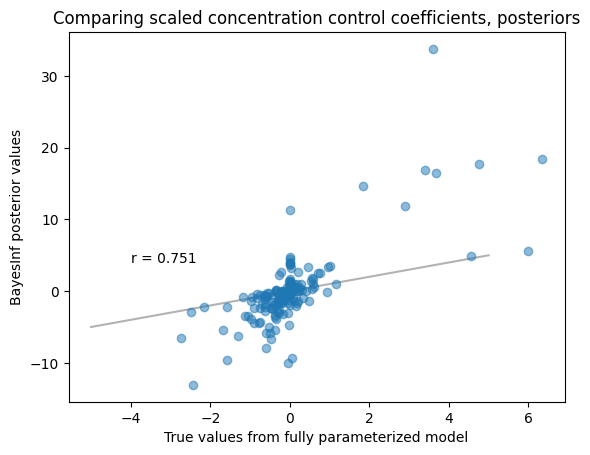

In [27]:
fig = plt.figure()

plt.scatter(gtCCC, postCCC, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled concentration control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-4,4,'r = ' + str((stats.pearsonr(gtCCC.to_numpy().flatten(), postCCC.to_numpy().flatten())[0]).round(3)))

Text(-1, 2, 'r = 0.503')

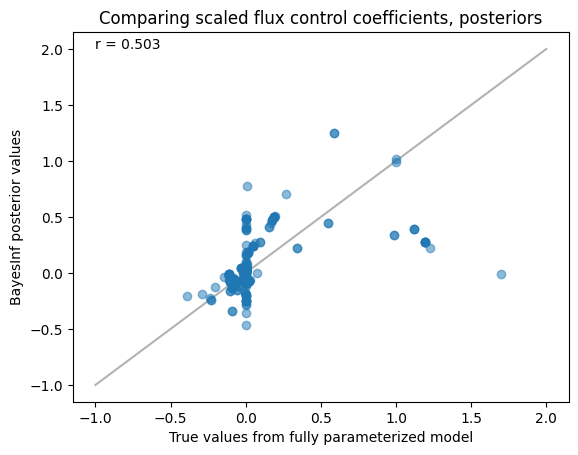

In [28]:
fig = plt.figure()

plt.scatter(gtFCC, postFCC, alpha=0.5)
plt.plot([-1,2], [-1,2], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-1,2,'r = ' + str((stats.pearsonr(gtFCC.to_numpy().flatten(), postFCC.to_numpy().flatten())[0]).round(3)))

## Pairwise comparison of FCC values

In [51]:
postFCC

,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH,vATP
vGLK,0.369914,0.334122,-0.068608,-0.039247,0.489646,0.226753,0.304656,0.166634,0.211857,0.111620,-0.014534,-0.319296,-0.411871,0.489185,-0.368507,0.068539,-0.550863
vPGI,0.501689,0.516396,-0.159666,-0.110846,0.717713,0.321505,0.402691,0.203252,0.227388,0.075296,-0.075918,-0.535748,-0.617793,0.603590,-0.646121,0.171361,-0.594789
vGLYCO,-0.845259,-1.186707,1.115237,0.090211,-1.442012,-0.571545,-0.543019,-0.163349,0.060748,0.417453,0.511242,1.524376,1.383871,-0.702383,1.989824,-0.708394,0.069707
vTreha,-0.234600,-0.702105,-0.081057,0.952721,-0.770965,-0.302266,-0.215520,-0.010966,0.150459,0.314681,0.317412,0.864114,0.661780,0.135067,1.157187,-0.617220,-0.618722
vPFK,0.501689,0.516396,-0.159666,-0.110846,0.717713,0.321505,0.402691,0.203252,0.227388,0.075296,-0.075918,-0.535748,-0.617793,0.603590,-0.646121,0.171361,-0.594789
vALD,0.501689,0.516396,-0.159666,-0.110846,0.717713,0.321505,0.402691,0.203252,0.227388,0.075296,-0.075918,-0.535748,-0.617793,0.603590,-0.646121,0.171361,-0.594789
vGAPDH,0.454824,0.457288,-0.136734,-0.095234,0.628085,0.284646,0.376277,0.193394,0.229124,0.096519,-0.049452,-0.447875,-0.555507,0.514351,-0.522774,0.071572,-0.498503
vPGK,0.454824,0.457288,-0.136734,-0.095234,0.628085,0.284646,0.376277,0.193394,0.229124,0.096519,-0.049452,-0.447875,-0.555507,0.514351,-0.522774,0.071572,-0.498503
vPGM,0.454824,0.457288,-0.136734,-0.095234,0.628085,0.284646,0.376277,0.193394,0.229124,0.096519,-0.049452,-0.447875,-0.555507,0.514351,-0.522774,0.071572,-0.498503
vENO,0.454824,0.457288,-0.136734,-0.095234,0.628085,0.284646,0.376277,0.193394,0.229124,0.096519,-0.049452,-0.447875,-0.555507,0.514351,-0.522774,0.071572,-0.498503


In [54]:
def plot_pairwise_FCCs(yield_enzyme):
    priors = pd.DataFrame(visFCC.loc[yield_enzyme])
    priors['distribution'] = ['prior']* len(priors)
    posteriors = pd.DataFrame(postFCC.loc[yield_enzyme])
    posteriors['distribution'] = ['posterior']* len(posteriors)
    paired = pd.concat([priors, posteriors]).reset_index()
    pv_tbl = paired.pivot('index', 'distribution', yield_enzyme)

    fig = pv_tbl[['prior', 'posterior']].plot(kind='bar', colormap='winter')
    plt.title(f'FCCs for {yield_enzyme}, before & after Bayesian inference')
    
    for i,val in enumerate(gtFCC.loc[yield_enzyme].sort_index()):
        plt.axhline(y = val,    # Line on y = 0.2
                xmin = (i+0.2)/len(gtFCC[yield_enzyme]), # From the left
                xmax = (i+0.8)/len(gtFCC[yield_enzyme]), 
                c='red') # To the right

C:\Users\user\AppData\Local\Temp\ipykernel_11568\3001363230.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.

C:\Users\user\AppData\Local\Temp\ipykernel_11568\3001363230.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.

C:\Users\user\AppData\Local\Temp\ipykernel_11568\3001363230.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.

C:\Users\user\AppData\Local\Temp\ipykernel_11568\3001363230.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.

C:\Users\user\AppData\Local\Temp\ipykernel_11568\3001363230.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.

C:\Users\user\AppData\Local\Temp\ipykernel_11568\3001363230.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword

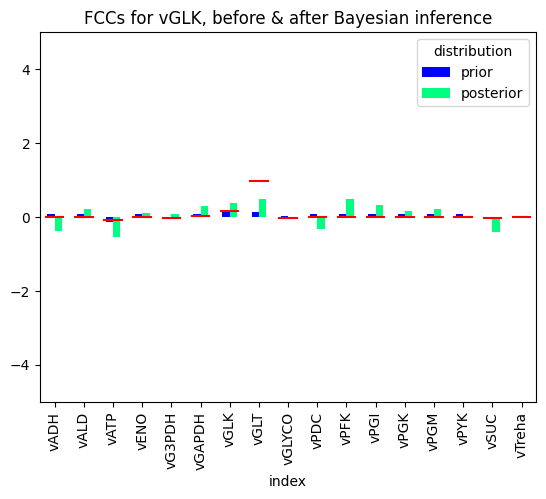

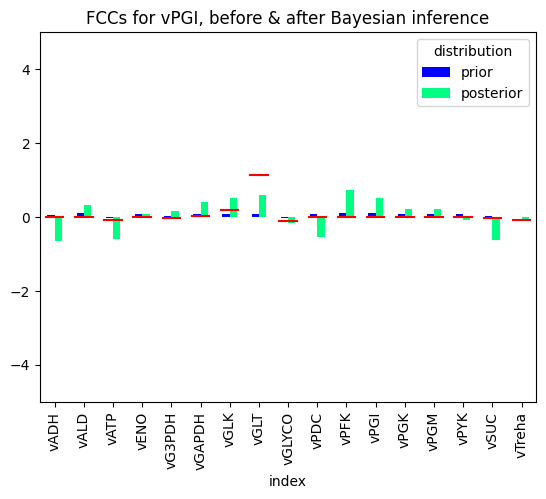

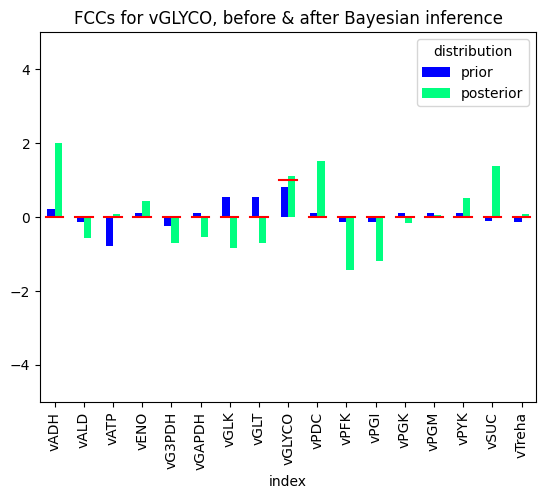

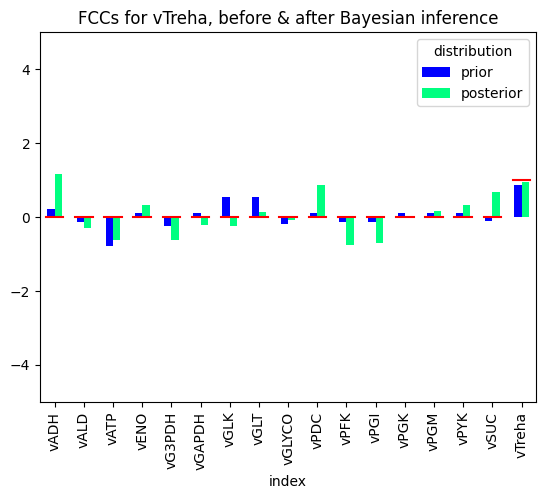

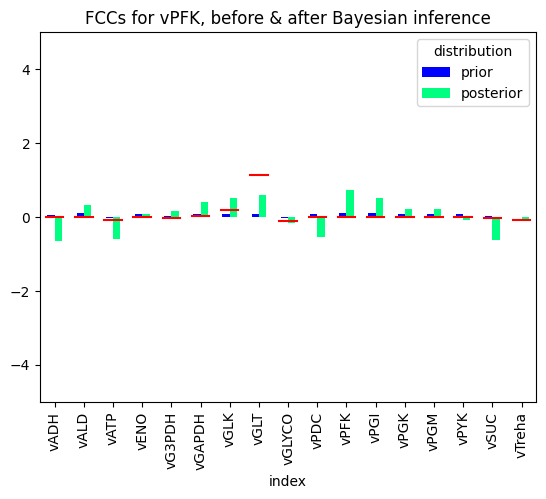

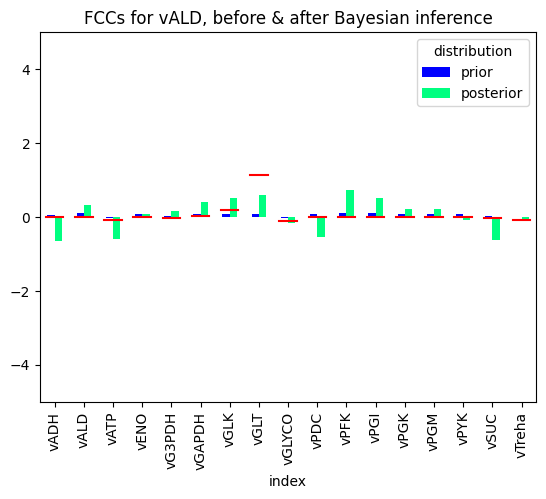

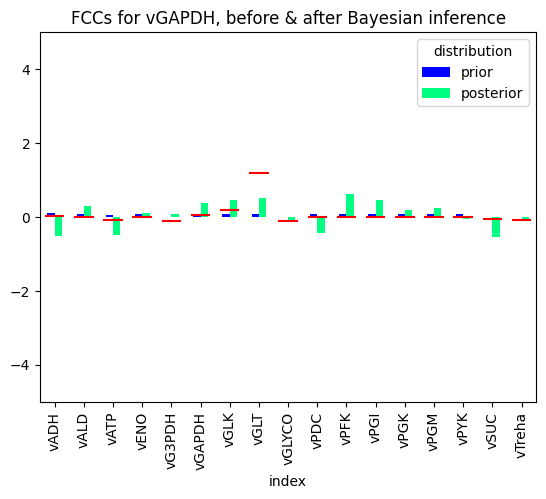

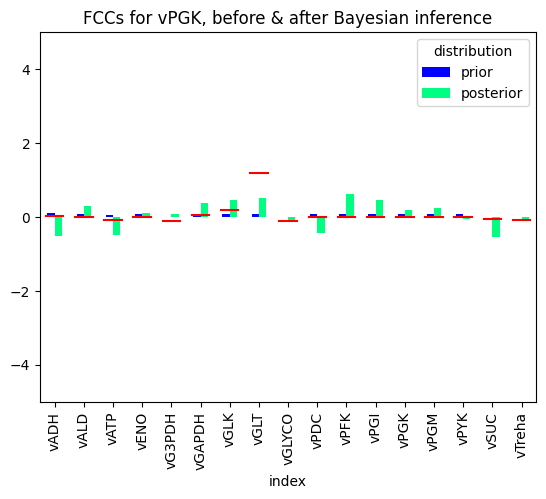

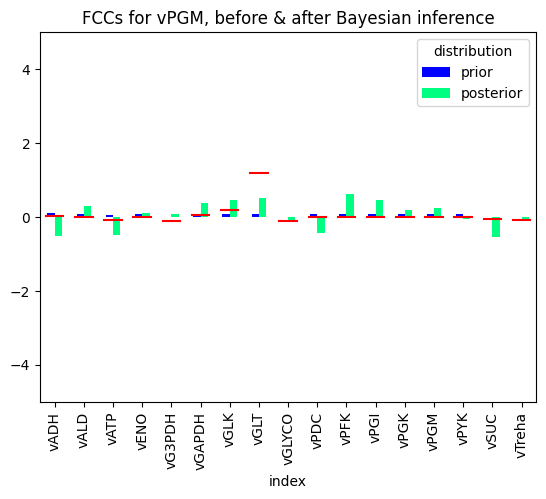

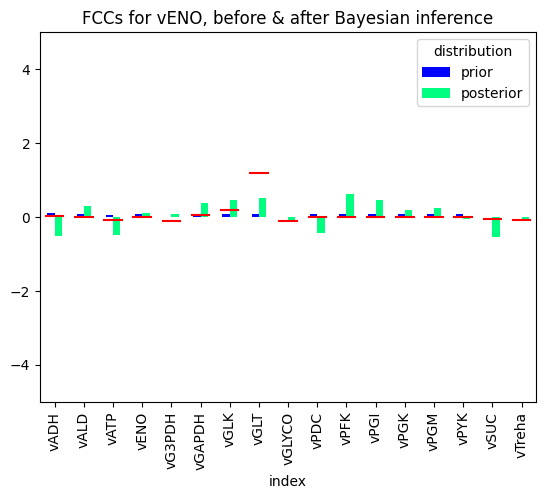

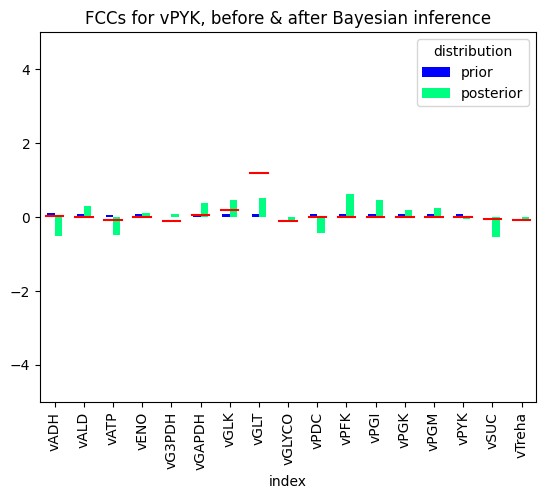

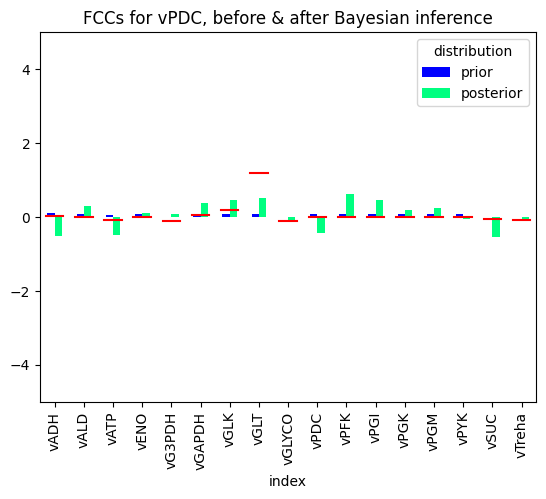

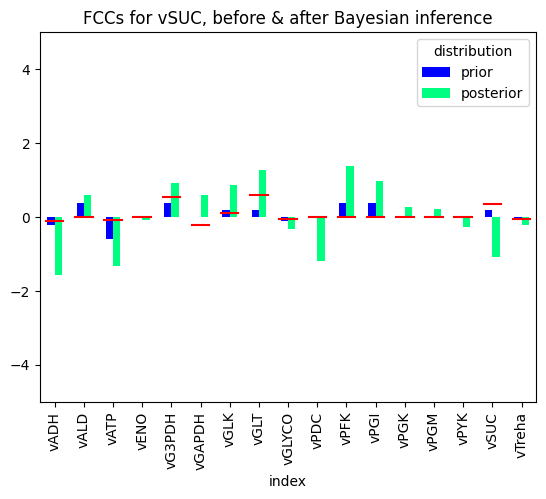

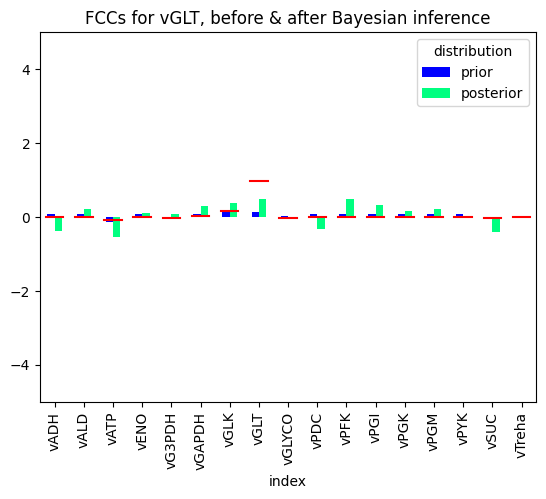

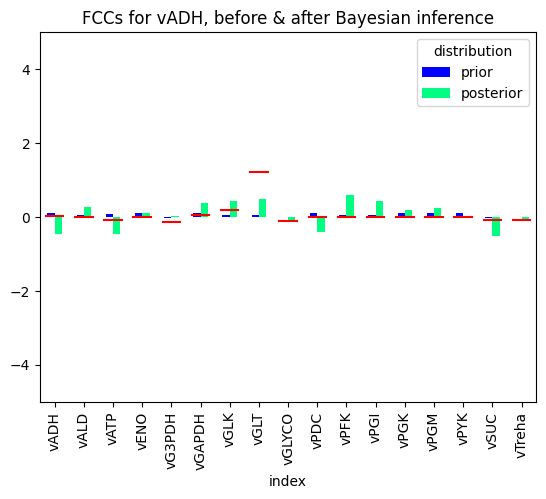

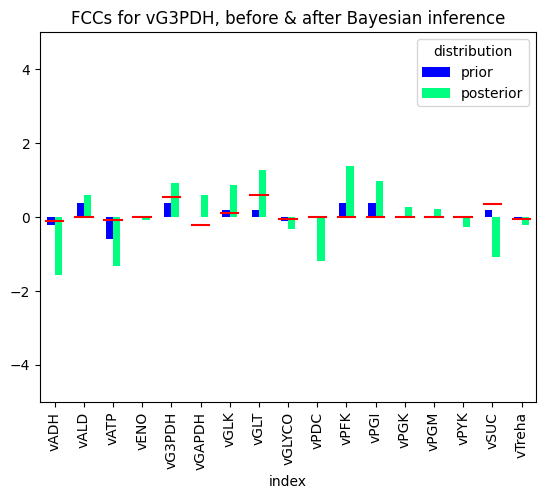

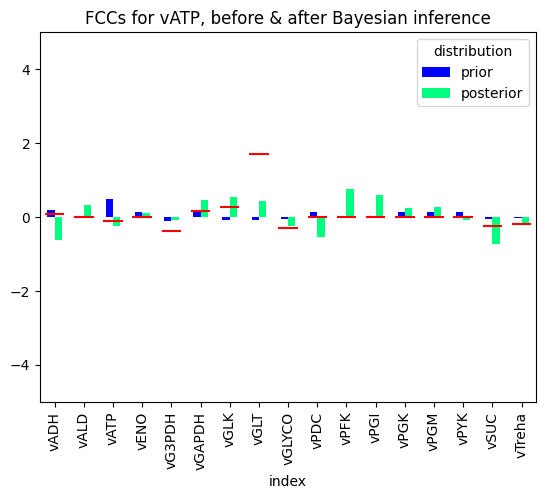

In [55]:
for i,rxn in enumerate(r.getReactionIds()):
    plot_pairwise_FCCs(rxn)

## Ranking FCC values

In [33]:
def rank_FCC_values(yield_enzyme): 
    FCCrankings = pd.concat([gtFCC.loc[yield_enzyme].rank(), visFCC.loc[yield_enzyme].rank(), postFCC.loc[yield_enzyme].rank()], axis=1)
    FCCrankings.columns=['gt', 'visE', 'postE']

    fig = plt.figure()

    plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
    plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
    plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
    plt.title(f'Comparing scaled flux control coefficient rankings, {yield_enzyme}')
    plt.xlabel('ordinal values from fully parameterized model')
    plt.ylabel('ordinal values from linlog approximations')

    plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
    plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
    plt.text(13,0,'Wilcoxon p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))
    plt.legend()

    FCCrankings['visE_dif'] = FCCrankings['visE'] - FCCrankings['gt']
    FCCrankings['postE_dif'] = FCCrankings['postE'] - FCCrankings['gt']
    FCCrankings.sort_values('gt')[['visE_dif','postE_dif']].plot(kind='bar', align='edge', width=0.7, alpha=0.7)
    plt.title(f'Rankings of FCC values for {yield_enzyme} predicted by Bayesian inference')
    plt.xlabel("reactions in order of gt FCC ranking")
    plt.ylabel("FCC ranking")

    return FCCrankings.sort_values('gt')

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.



,gt,visE,postE,visE_dif,postE_dif
vG3PDH,1.0,1.0,8.0,0.0,7.0
vGLYCO,2.0,4.0,5.0,2.0,3.0
vATP,3.0,5.0,2.0,2.0,-1.0
vTreha,4.0,3.0,7.0,-1.0,3.0
vSUC,5.0,2.0,3.0,-3.0,-2.0
vALD,6.0,9.0,13.0,3.0,7.0
vPDC,7.0,13.0,6.0,6.0,-1.0
vPGM,8.0,15.0,12.0,7.0,4.0
vPGK,9.0,12.0,9.0,3.0,0.0
vPYK,10.0,14.0,16.0,4.0,6.0


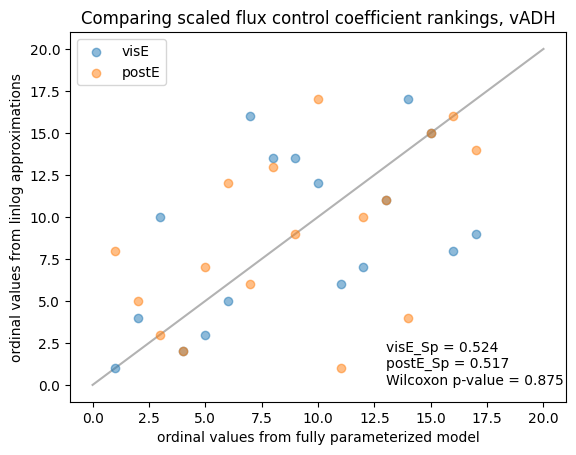

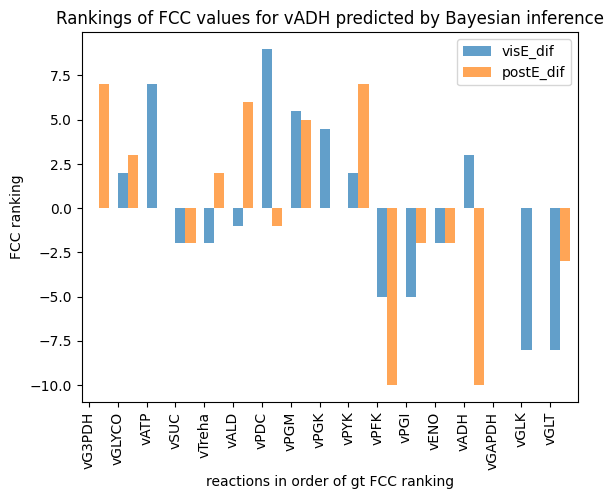

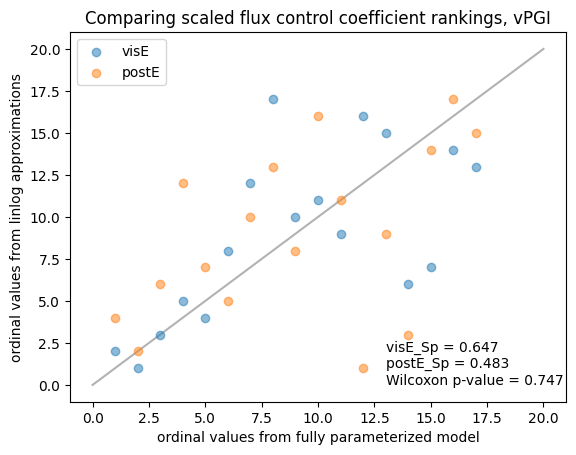

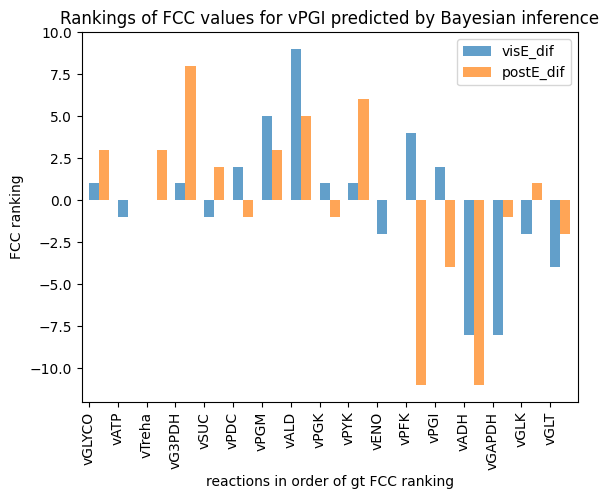

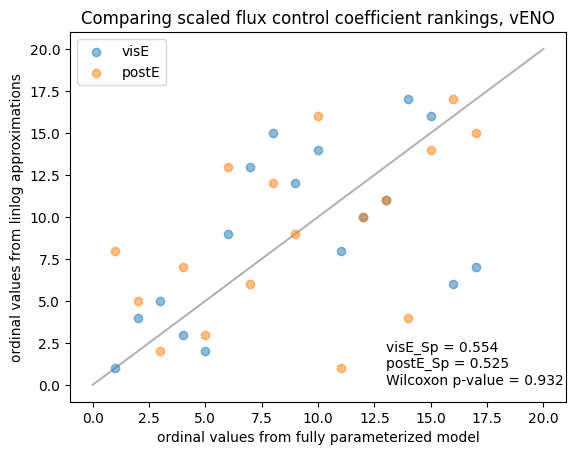

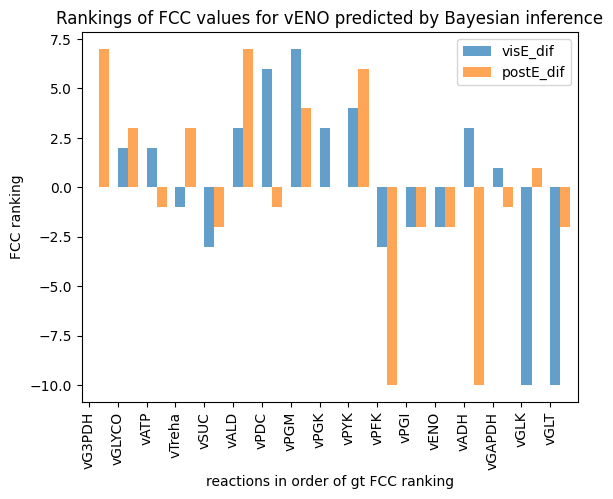

In [34]:
rank_FCC_values('vADH')
rank_FCC_values('vPGI')
rank_FCC_values('vENO')

## Distribution of FCC Sp. correlation coefficients

In [35]:
visE_r=[]
postE_r=[]

for i in r.getReactionIds():        
    FCCrankings = pd.concat([gtFCC.loc[i].rank(), visFCC.loc[i].rank(), postFCC.loc[i].rank()], axis=1)
    FCCrankings.columns=['gt', 'visE', 'postE']

    visE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0])
    postE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0])


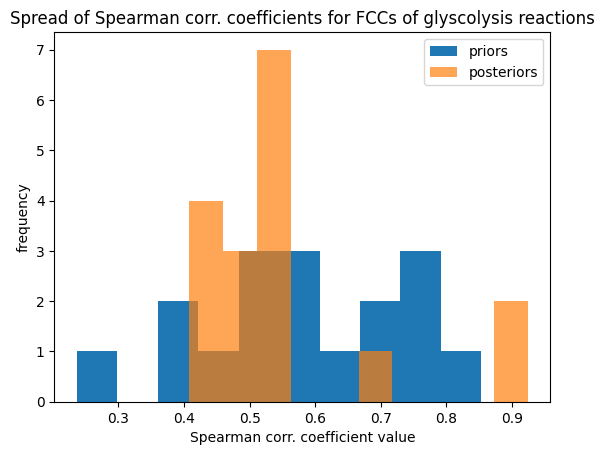

In [36]:
plt.hist(visE_r, label='priors')
plt.hist(postE_r, alpha=0.7, label='posteriors')
plt.legend()
plt.xlabel('Spearman corr. coefficient value')
plt.ylabel('frequency')
plt.title('Spread of Spearman corr. coefficients for FCCs of glyscolysis reactions')

plt.show()
